In [1]:
from Assemblies.game import GameField
import numpy as np
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [2]:
eps = 0.01
b = 9/5+eps
cp = 50
seeds = np.array([i for i in range(1, 201)])

#процент заполненности решётки, при котором достигается пиковое значение плотности кооператоров
p_star = 80.5
#левая окрестность точки p_star 
points = np.linspace(60, p_star, num=42, dtype=float)
#правая окрестность точки p_star
pointsr = np.linspace(p_star, 100, num=10, dtype=float)


sizes = np.array([35, 50, 68, 86, 100, 150, 200])
ls = len(sizes)
n = len(seeds)
m = len(points)
mr = len(pointsr)

Вычисляется функция $P(0, \infty)$ - процент игроков, ни разу не менявших свою стратегию на протяжении всего эксперимента с самого его начала. После совершении определённого числа шагов значение $P$ выходит на плато. Наша задача - проводить эксперимент, пока $P$ не выйдет на плато. 

Таким образом, эксперимент прерывается по 4 причинам:
 - поле приходит в стационарное состояние
 - поле непостоянно, но присутствуют устойчивые структуры. Будем проверять это на протяжении 1000 ходов.
 - все игроки меняют стратегию хотя бы раз
 - поле совершает установленное число шагов эволюции. Пусть 10000.

In [3]:
def make_field(L, coop_percentage, off_percentage, seed):
    '''
    ---Формирование поля для одного seed---
    
    принимает на вход
    - L - размер поля
    - coop_percentage - начальный процент кооператоров
    - off_percentage - процент отключенных узлов - их количество и расположение на поле постоянно. 
    Величина равна 100 - процент заполненности решётки
    - seed - начальное условие генератора для повторяемости результата
    
    возвращает
    - field - поле по заданным начальным условиям
    '''
    np.random.seed(seed)
    field = np.array(np.random.rand(L, L) <= 0.01 * off_percentage, dtype=int) * (-1)
    active_indexes = (field + 1).nonzero()
    active_size = active_indexes[0].size
    active = np.array(np.random.rand(active_size) > 0.01 * coop_percentage, dtype=int)
    field[active_indexes] = np.copy(active)
    return field

def P(field, b):
    '''
    ---Вычисление P(0, \infty)---
    
    принимает на вход
    - field - поле
    - b - коэффициент выигрыша

    возвращает
    - P
    '''
    active_indexes = (field + 1).nonzero()
    active_size = active_indexes[0].size
    #флаги прохождения проверки на неизменность стратегий: 1 - прошёл, 0 - нет
    flags = np.ones(active_size, dtype=int)
    
    
    L = field[0].size
    game = GameField(L, b)
    game.field = np.copy(field)
    pers_steps = 0
    
    for step in range(10000):
        past = np.copy(game.field[active_indexes])
        game.evolveQ(1)
        now = np.copy(game.field[active_indexes])
        if np.all(past == now):
            break
        #берём игроков, не менявших стратегию за step-1 ходов, и выясняем сколько осталось таких чрез ход
        past_test = past[flags.nonzero()]
        now_test = now[flags.nonzero()]
        #получившийся булевый массив превращаем в 0 и 1 и меняем флаги 
        new_flags = list(map(int, past_test == now_test))
        flags[flags.nonzero()] = new_flags
        if all(nf == 1 for nf in new_flags):
            pers_steps += 1
        else:
            pers_steps = 0
        if pers_steps == 1000:
            break
        if np.count_nonzero(flags) == 0:
            break
    return np.count_nonzero(flags) / active_size

### вычисление persistence

In [4]:
left = np.zeros((ls, n, m))
right = np.zeros((ls, n, mr))
for s in range(ls):
    persl = np.zeros((n, m))
    persr = np.zeros((n, mr))
    for i in range(n):
        for j in range(m):
            field = make_field(sizes[s], cp, 100 - points[j], seeds[i])
            persl[i][j] = P(field, b)
        for j in range(mr):
            field = make_field(sizes[s], cp, 100 - pointsr[j], seeds[i])
            persr[i][j] = P(field, b)
    left[s] = persl
    right[s] = persr

### запись в файл

In [5]:
for s in range(ls):
    linel = list(np.reshape(left[s], (n * m)))
    with open('pers' + str(sizes[s]) + '.txt', 'w', encoding='utf8') as f:
        json.dump(linel, f)
    
    liner = list(np.reshape(right[s], (n * mr)))
    with open('pers' + str(sizes[s]) + 'r.txt', 'w', encoding='utf8') as f:
        json.dump(liner, f)

### чтение из файла

In [6]:
copyl = np.zeros((ls, n, m))
copyr = np.zeros((ls, n, mr))
for s in range(ls):
    with open('pers' + str(sizes[s]) + '.txt', 'r', encoding='utf8') as f:
        copyl[s] = np.reshape(np.array(json.load(f)), (n, m))
        
    with open('pers' + str(sizes[s]) + 'r.txt', 'r', encoding='utf8') as f:
        copyr[s] = np.reshape(np.array(json.load(f)), (n, mr))

### вычисление средних и ошибок

In [7]:
averl = np.zeros((ls, m))
errl = np.zeros((ls, m))
averr = np.zeros((ls, mr))
errr = np.zeros((ls, mr))
for s in range(ls):
    averl[s] = np.mean(copyl[s], axis=0)
    for j in range(m):
        errl[s][j] = np.sqrt(sum((averl[s][j] - copyl[s][::, j]) ** 2) / n) / np.sqrt(n)
        
    averr[s] = np.mean(copyr[s], axis=0)
    for j in range(mr):
        errr[s][j] = np.sqrt(sum((averr[s][j] - copyr[s][::, j]) ** 2) / n) / np.sqrt(n)

In [8]:
full_aver = np.zeros((ls, m + mr))
full_err = np.zeros((ls, m + mr))
for s in range(ls):
    full_aver[s] = np.hstack((averl[s], averr[s]))
    full_err[s] = np.hstack((errl[s], errr[s]))

full_points = np.hstack((points, pointsr))

### построение графиков

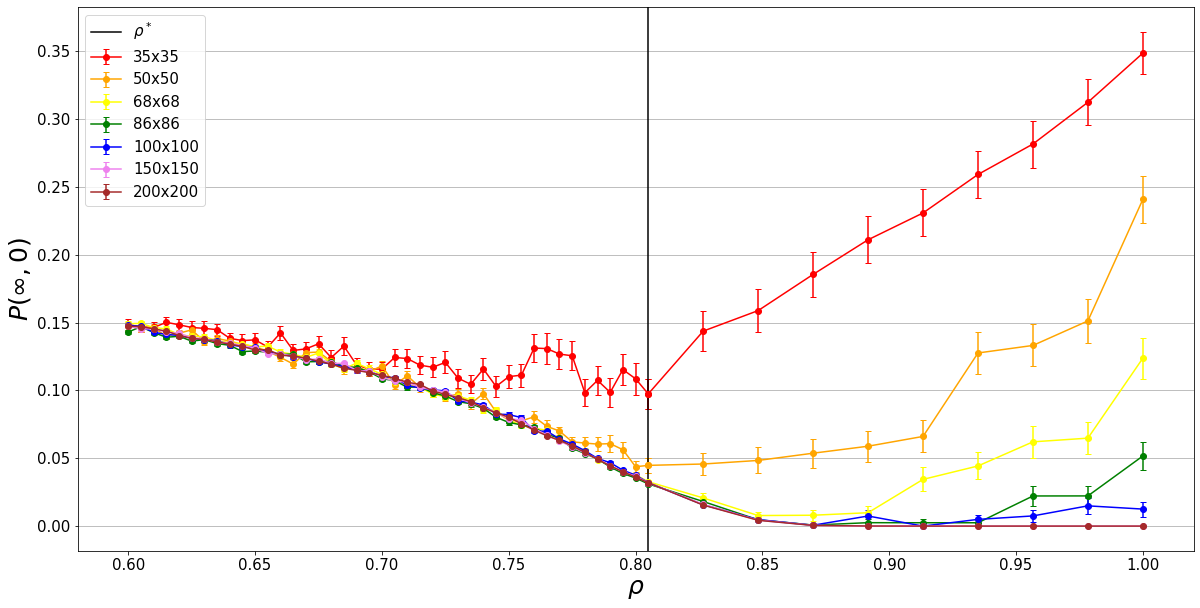

In [9]:
clrs = ['red', 'orange', 'yellow', 'green', 'blue', 'violet', 'brown']
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for s in range(ls):
    lab = str(sizes[s]) + 'x' + str(sizes[s])
    ax.errorbar(full_points * 0.01, full_aver[s], full_err[s], fmt='o-', capsize=3, label=lab, color=clrs[s])
ax.axvline(p_star * 0.01, label='$%s$'%'\\rho^*', color='black')
ax.set_xlabel('$%s$'%'\\rho',fontsize=25)
ax.set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)
ax.legend(prop={'size': 15})
ax.tick_params(axis='both', which='major', labelsize=15)
ax.grid(b=True,axis='y')

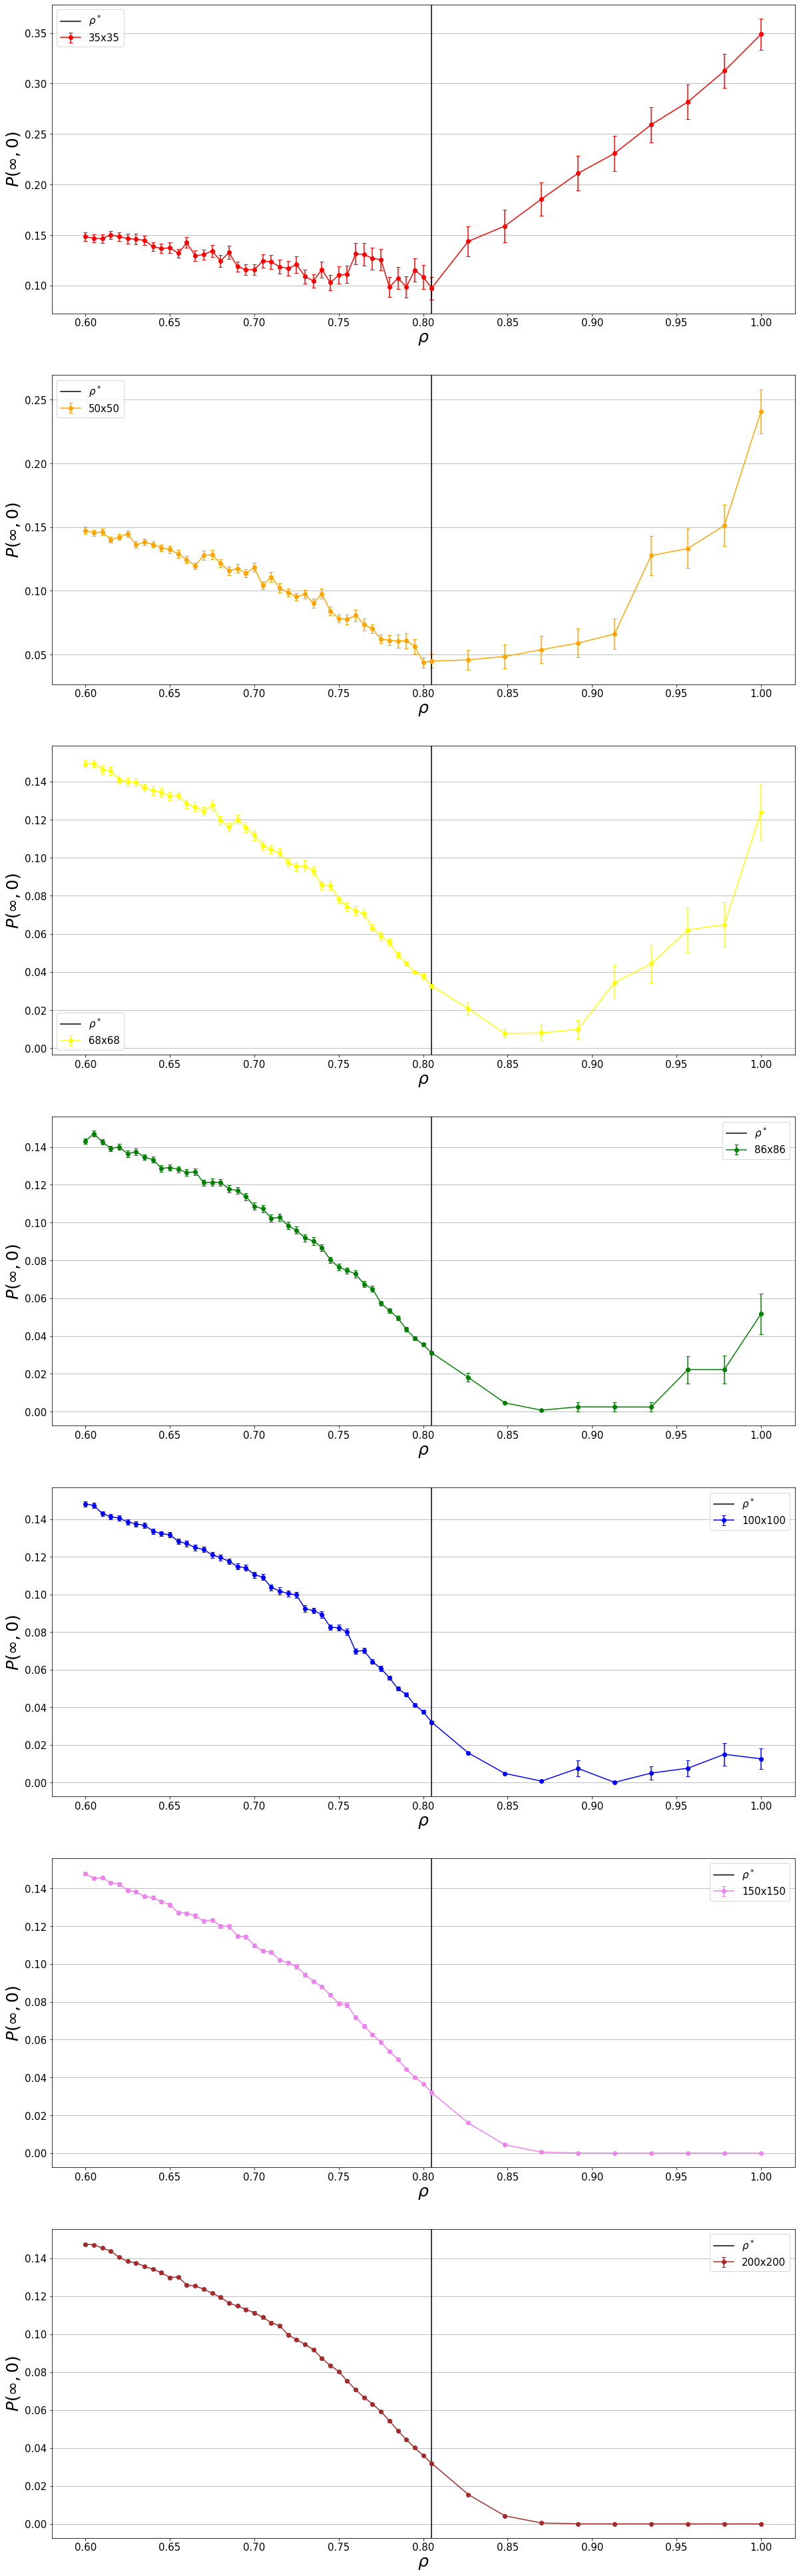

In [10]:
fig, ax = plt.subplots(ls, 1, figsize=(20, 10 * ls))

for s in range(ls):
    lab = str(sizes[s]) + 'x' + str(sizes[s])
    ax[s].errorbar(full_points * 0.01, full_aver[s], full_err[s], fmt='o-', capsize=3, label=lab, color=clrs[s])
    ax[s].axvline(p_star * 0.01, label='$%s$'%'\\rho^*', color='black')
    ax[s].set_xlabel('$%s$'%'\\rho',fontsize=25)
    ax[s].set_ylabel('$%s$'%'P(\\infty,0)',fontsize=25)
    ax[s].legend(prop={'size': 15})
    ax[s].tick_params(axis='both', which='major', labelsize=15)
    ax[s].grid(b=True,axis='y')

In [11]:
def make_hyst(data, bins = 7):
    '''
    ---Построение диаграммы распределения P(inf, 0)---
    
    принимает на вход
    - data - результаты измерения P(inf, 0) для определённого размера поля и процента заполненности решётки
    - bins - количество столбцов гистограммы
    
    '''
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.hist(data, bins)
    ax.set_ylabel('Частота',fontsize=25)
    ax.set_xlabel('$%s$'%'P(\\infty,0)',fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.grid(b=True,axis='y')

In [12]:
print(sizes[1], sizes[2], sizes[4])
print(points[21], points[41], pointsr[2])

50 68 100
70.5 80.5 84.83333333333333


### гистограммы

# 50 x 50

#### $\rho = 0.75$ 

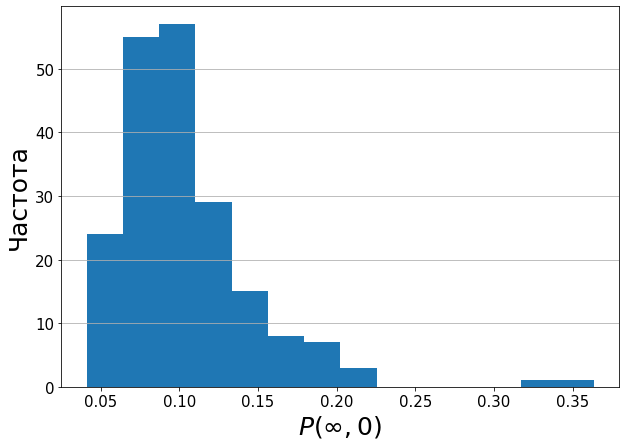

In [25]:
make_hyst(copyl[1, :, 21], 14)

#### $\rho = \rho^*$ 

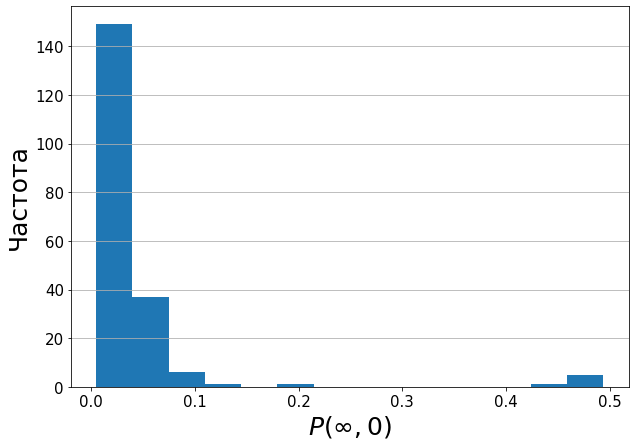

In [23]:
make_hyst(copyl[1, :, 41], 14)

#### $\rho = 0.85$ 

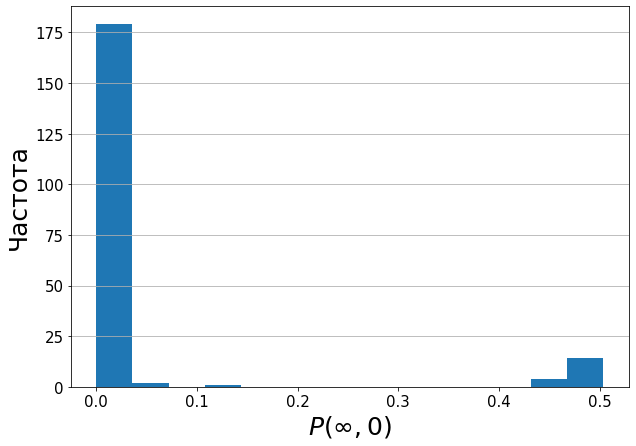

In [15]:
make_hyst(copyr[1, :, 2], 14)

# 68 x 68

#### $\rho = 0.75$ 

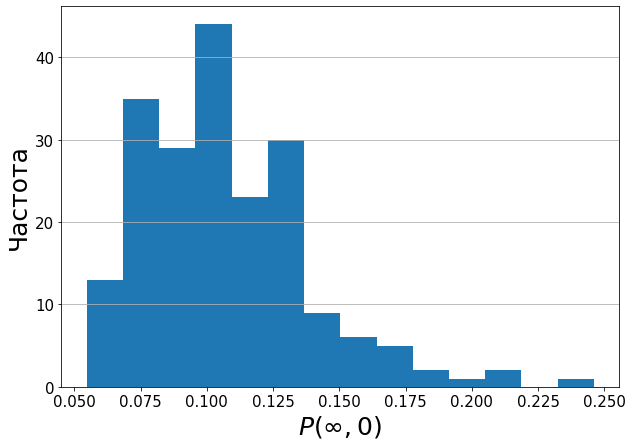

In [16]:
make_hyst(copyl[2, :, 21], 14)

#### $\rho = \rho^*$ 

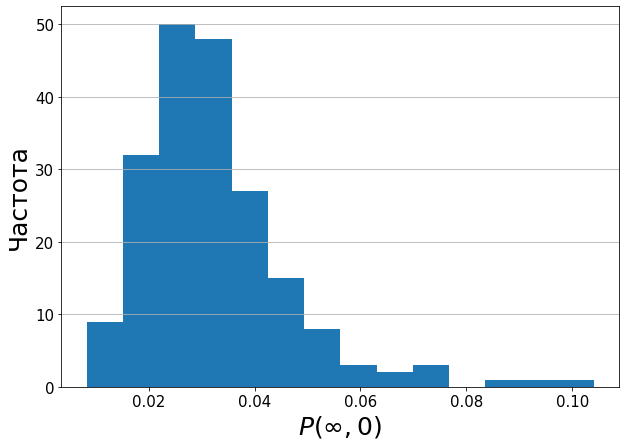

In [17]:
make_hyst(copyl[2, :, 41], 14)

#### $\rho = 0.85$ 

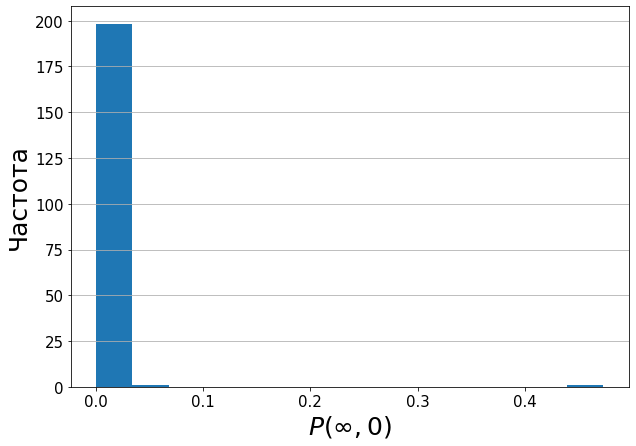

In [18]:
make_hyst(copyr[2, :, 2], 14)

# 100 x 100

#### $\rho = 0.75$ 

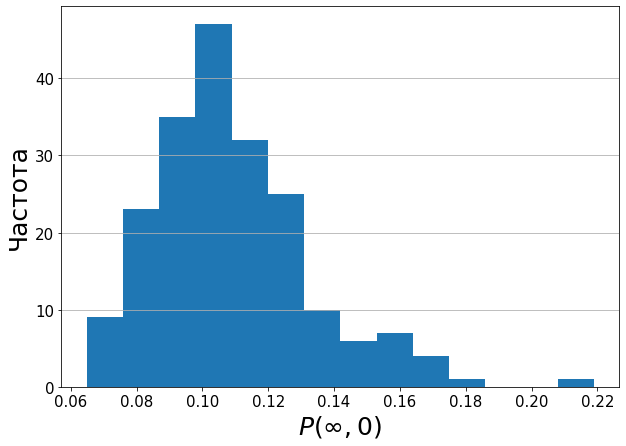

In [19]:
make_hyst(copyl[4, :, 21], 14)

#### $\rho = \rho^*$ 

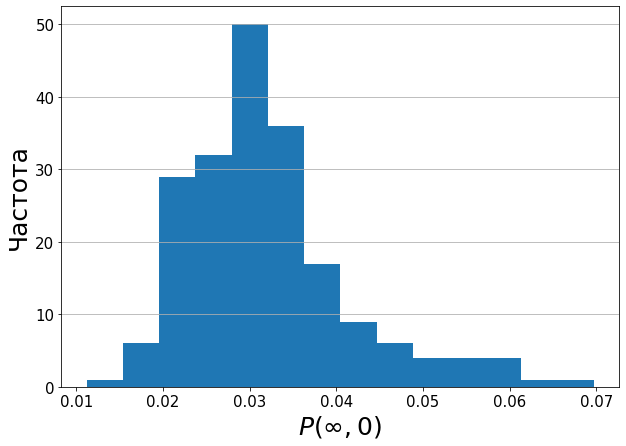

In [20]:
make_hyst(copyl[4, :, 41], 14)

#### $\rho = 0.85$ 

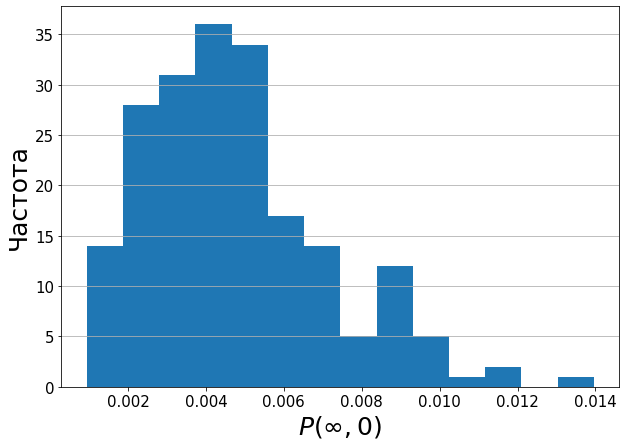

In [21]:
make_hyst(copyr[4, :, 2], 14)